4.709128918272134


C:\Users\Berjoska\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


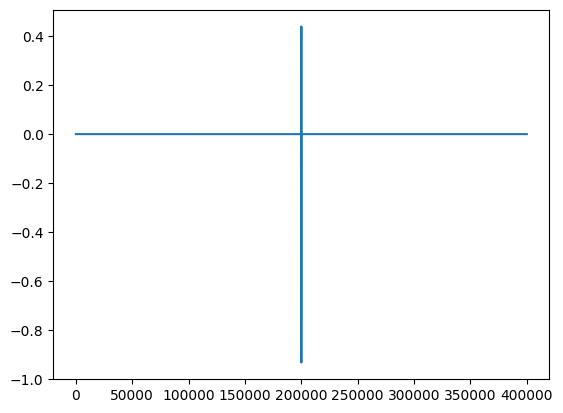

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft, fftfreq, fftshift
import math
import matplotlib.ticker as ticker

def E_of_t_laser(fwhm, t, t_0, w_0):
    return np.exp((-2*math.log(2)*((t - t_0)**2))/(fwhm**2))*np.exp(-1j*w_0*t)

fwhm = 10
c = 299792458
w_0 = 2*np.pi*c*1e-15/800e-9
print(w_0*2)
t_0 = 200000
Npts = 2**17
ts = np.linspace(0, 400000, Npts)
dt = ts[1] - ts[0]
#ts = np.linspace(150, 250, 500)
Es = E_of_t_laser(fwhm, ts, t_0, w_0)


plt.plot(ts, Es)


0.00018564263846582258


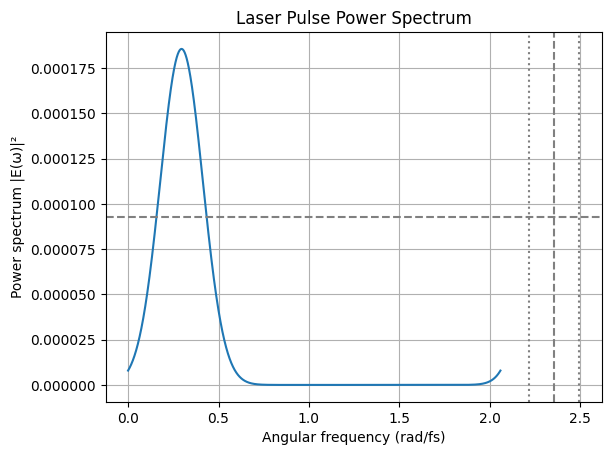

In [2]:
'''
Mathematica's Fourier transform uses a positively-signed (clockwise-spinned) exponent, whereas
Python uses a negatively-signed exponent. This has the effect of conjugating the input and output,
so we use np.conj to get results matching Mathematica

norm = 'ortho' scales both forward and backward transforms by 1/sqrt(N) (N number of points)
'''
Ews = np.conj(fft(np.conj(Es), norm = 'ortho'))

#matching Mathematica code way to get ws
ws = 2 * np.pi * np.arange(Npts) / (Npts * dt)

Ews_power = np.abs(Ews)**2
maxU = np.max(Ews_power)
print(maxU)

plt.plot(ws, Ews_power)
plt.axhline(maxU / 2, color='gray', linestyle='--')  # horizontal at half max
plt.axvline(w_0, color='gray', linestyle='--')        # center frequency
plt.axvline(2.2159, color='gray', linestyle=':')     # example verticals
plt.axvline(2.4932, color='gray', linestyle=':')

plt.xlabel("Angular frequency (rad/fs)")
plt.ylabel("Power spectrum |E(ω)|²")
plt.title("Laser Pulse Power Spectrum")
plt.grid()
plt.show();

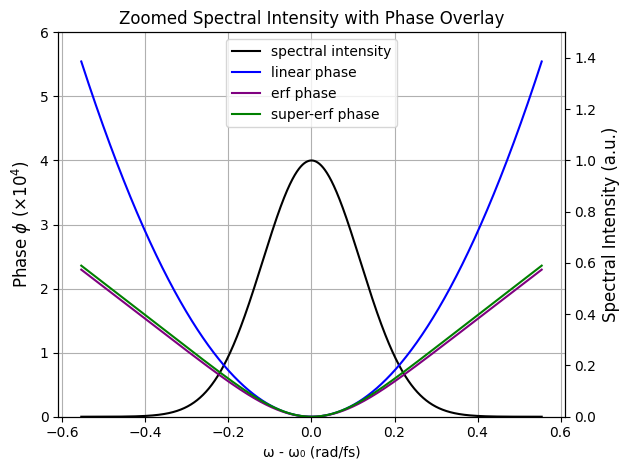

In [4]:
from scipy.special import erf

def chirper(Ews, phi):
    return Ews*np.exp(1j*phi)

def lin_chirp(A, w, w_0):
    return A*((w - w_0)**2)

#erf chirp equation from the paper -> noah says the square was a typo; so this is wrong
def erf_chirp(B, w, w_0, sigma):

    x = (w - w_0)*sigma/math.sqrt(4*math.log(2))

    return B*(((np.exp(-x**2) - 1)/math.sqrt(np.pi) + x*erf(x))**2)

#erf chirp from the mathematica code
def erf_2(B, w, w_0, sigma):
    x = (w - w_0)*2*sigma/math.sqrt(2*math.log(256))
    return B*((np.exp(-x**2) - 1)/math.sqrt(np.pi) + x*erf(x))

#super erf chirp from mathematica code 
def superf_chirp(C, w, w_0, sigma_s):
    x = (w - w_0)*2*sigma_s / math.sqrt(2*math.log(256))
    return C*((np.exp(-x**2) - 1)/math.sqrt(np.pi) + x*erf(x))


A = 180337
B = 8300
C = 7450

sigma_s = 1.12*fwhm #she had this hardcoded in to her super erf function

pos_lin = lin_chirp(A, ws, w_0)
neg_lin = lin_chirp(-A, ws, w_0)

pos_erf = erf_2(B, ws, w_0, fwhm)
neg_erf = erf_2(-B, ws, w_0, fwhm)

pos_superf = superf_chirp(C, ws, w_0, sigma_s)
neg_superf = superf_chirp(-C, ws, w_0, sigma_s)


ws_centered = ws - w_0
power_norm = Ews_power / maxU 

# Zoom in: find center index and plot surrounding region
i_center = np.argmin(np.abs(ws - w_0))
window = 2 * 17651
i_start = max(i_center - window, 0)
i_end = min(i_center + window, len(ws))

# Plot
fig, ax1 = plt.subplots()

# Left y-axis: Phase (shifted by - w_0 to align with 0 on x axis)
ax1.plot(ws_centered[i_start:i_end], power_norm[i_start:i_end] * 4, color='black', label='spectral intensity') # multiplied by 4 because maggie does it; ask why
ax1.plot(ws_centered[i_start:i_end], pos_lin[i_start:i_end] / 1e4, label='linear phase', color='blue') # /1e4 for scaling
ax1.plot(ws_centered[i_start:i_end], pos_erf[i_start:i_end] / 1e4, label='erf phase', color='purple')
ax1.plot(ws_centered[i_start:i_end], pos_superf[i_start:i_end] / 1e4, label='super-erf phase', color='green')
ax1.set_ylim(0, 6)
ax1.set_xlabel("ω - ω₀ (rad/fs)")
ax1.set_ylabel(r"Phase $\phi$ ($\times10^4$)", fontsize=12)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid(True)

# --- Create secondary y-axis sharing the x-axis
ax2 = ax1.twinx()

# Map ax2 limits: 0 to 1.5 a.u. corresponds to 0 to 6 on other plot
ax2.set_ylim(0, 1.5)
ax2.set_ylabel("Spectral Intensity (a.u.)", fontsize=12)

# --- Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center')

plt.title("Zoomed Spectral Intensity with Phase Overlay")
plt.tight_layout()
plt.show()

In [5]:

Ec_lin = chirper(Ews, pos_lin)
Ea_lin = chirper(Ews, neg_lin)

Ec_erf = chirper(Ews, pos_erf)
Ea_erf = chirper(Ews, neg_erf)

Ec_superf = chirper(Ews, pos_superf)
Ea_superf = chirper(Ews, neg_superf)

Ec_lin_t = np.conj(ifft(np.conj(Ec_lin), norm = 'ortho'))
Ec_erf_t = np.conj(ifft(np.conj(Ec_erf), norm = 'ortho'))
Ec_superf_t = np.conj(ifft(np.conj(Ec_superf), norm = 'ortho'))

print(len(ts))
print(len(ws))
print(len(Ews))

#plt.plot(ts, np.abs(Es)**2)
#this is much smaller height wise than expected, but about as wide?
#plt.plot(ts, np.abs(Ec_lin_t)**2)
#plt.plot(ts, np.abs(Ec_erf_t)**2)
#plt.plot(ts, np.abs(Ec_superf_t)**2)


524288
524288
524288


okaie trying with linear nowww

In [13]:

def Ereffer(Ec, Ea, w, tau):
    return (Ec + Ea)*np.exp(1j*w*tau)

def Esampler(Ec, Ea, w, w_0, epsilon):
    return (Ec - Ea)*np.exp(1j*epsilon*((w - w_0)**2))

#need to calculate these in frequency domain, then ifft into time domain

taus = np.arange(-25, 25 + 0.5, 0.5)
taus = np.arange(0, 200 + 0.5, 0.5)
'''
Esamp_lin_w = Esampler(Ec_lin, Ea_lin, ws, w_0, 0)
Esamp_lin_t = np.conj(ifft(np.conj(Esamp_lin_w), norm = 'ortho'))

SFG_data = []

for tau in taus:
    Eref_lin_w = Ereffer(Ec_lin, Ea_lin, ws, tau)
    Esfg_lin_t = np.conj(ifft(np.conj(Eref_lin_w), norm = 'ortho'))*Esamp_lin_t
    Esfg_lin_w = np.conj(fft(np.conj(Esfg_lin_t), norm = 'ortho'))
    Isfg_lin_w = np.abs(Esfg_lin_w)**2
    SFG_data.append(Isfg_lin_w)

SFG_data = np.array(SFG_data)
'''

def CPI(Ec, Ea, ws, w_0, taus, epsilon):
    Esamp_w = Esampler(Ec, Ea, ws, w_0, epsilon)
    Esamp_t = np.conj(ifft(np.conj(Esamp_w), norm = 'ortho'))

    SFG_data = []

    for tau in taus:
        Eref_w = Ereffer(Ec, Ea, ws, tau)
        Esfg_t = np.conj(ifft(np.conj(Eref_w), norm = 'ortho'))*Esamp_t
        Esfg_w = np.conj(fft(np.conj(Esfg_t), norm = 'ortho'))
        Isfg_w = np.abs(Esfg_w)**2
        SFG_data.append(Isfg_w)

    SFG_data = np.array(SFG_data)
    return SFG_data

lin_cpi = CPI(Ec_lin, Ea_lin, ws, w_0, taus,  0.0223238*16000)
erf_cpi = CPI(Ec_erf, Ea_erf, ws, w_0, taus,  0.0223238*16000)
superf_cpi =CPI(Ec_superf, Ea_superf, ws, w_0, taus,  0.0223238*16000)


for some reasons maggies plot is one pixel wider on the y-axis than mine. is this because i removed the first points where w = 0?

C:\Users\Berjoska\AppData\Local\Temp\ipykernel_2680\2227476890.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


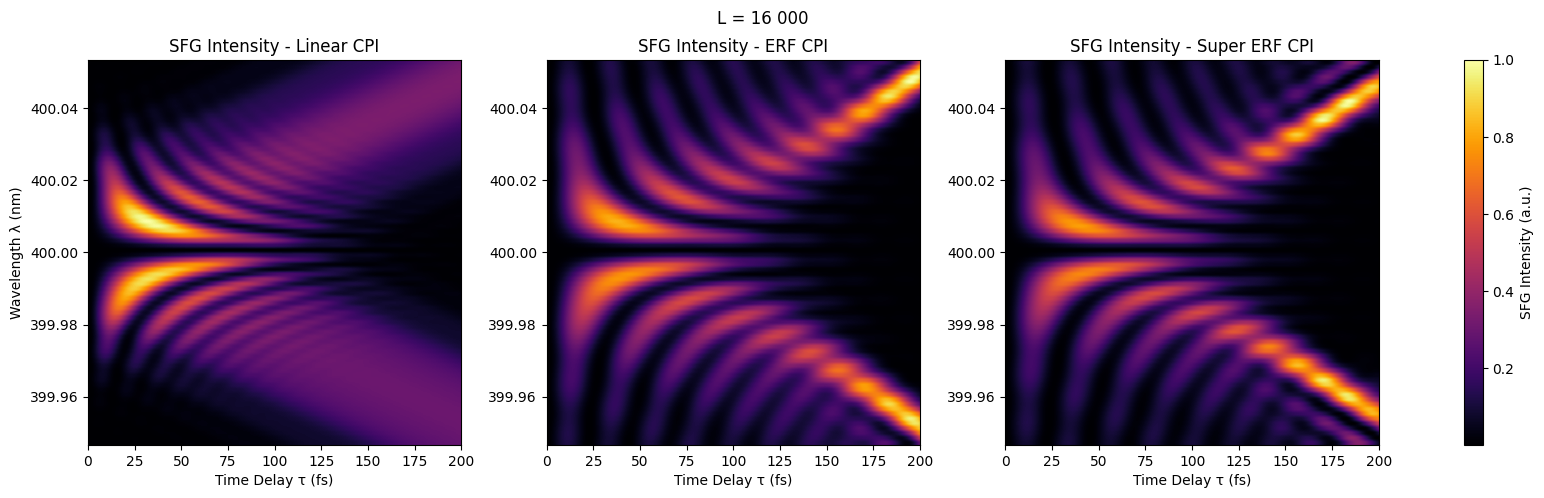

In [ ]:
from matplotlib import gridspec
#skipping the first bin of everything now
ws[0] = 1e-6

# --- Generate wavelength axis ---
wavelengths = 2 * np.pi * c * 1e9 / (ws * 1e15)

# --- Correct indices (Python is 0-based) ---
start = 299753
end = 299833

# --- Normalize datasets ---
lin_cpi_norm = lin_cpi / np.max(lin_cpi)
erf_cpi_norm = erf_cpi / np.max(erf_cpi)
superf_cpi_norm = superf_cpi / np.max(superf_cpi)

# --- Compute plotting extent ---
extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

# --- Set up figure with GridSpec (3 plots + 1 for colorbar) ---
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

axes = [fig.add_subplot(gs[i]) for i in range(3)]

datasets = [lin_cpi_norm, erf_cpi_norm, superf_cpi_norm]
titles = ['Linear CPI', 'ERF CPI', 'Super ERF CPI']

# --- Plot heatmaps ---
for ax, data, title in zip(axes, datasets, titles):
    im = ax.imshow(
        data[:, start:end].T,
        extent=extent,
        origin='lower',
        aspect='auto',
        cmap='inferno'
    )
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(f'SFG Intensity - {title}')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

axes[0].set_ylabel('Wavelength λ (nm)')

# --- Add colorbar in its own subplot space ---
cbar_ax = fig.add_subplot(gs[3])
fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')
fig.suptitle("L = 16 000")
plt.tight_layout()
plt.show();


C:\Users\Berjoska\AppData\Local\Temp\ipykernel_2680\1976062730.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title


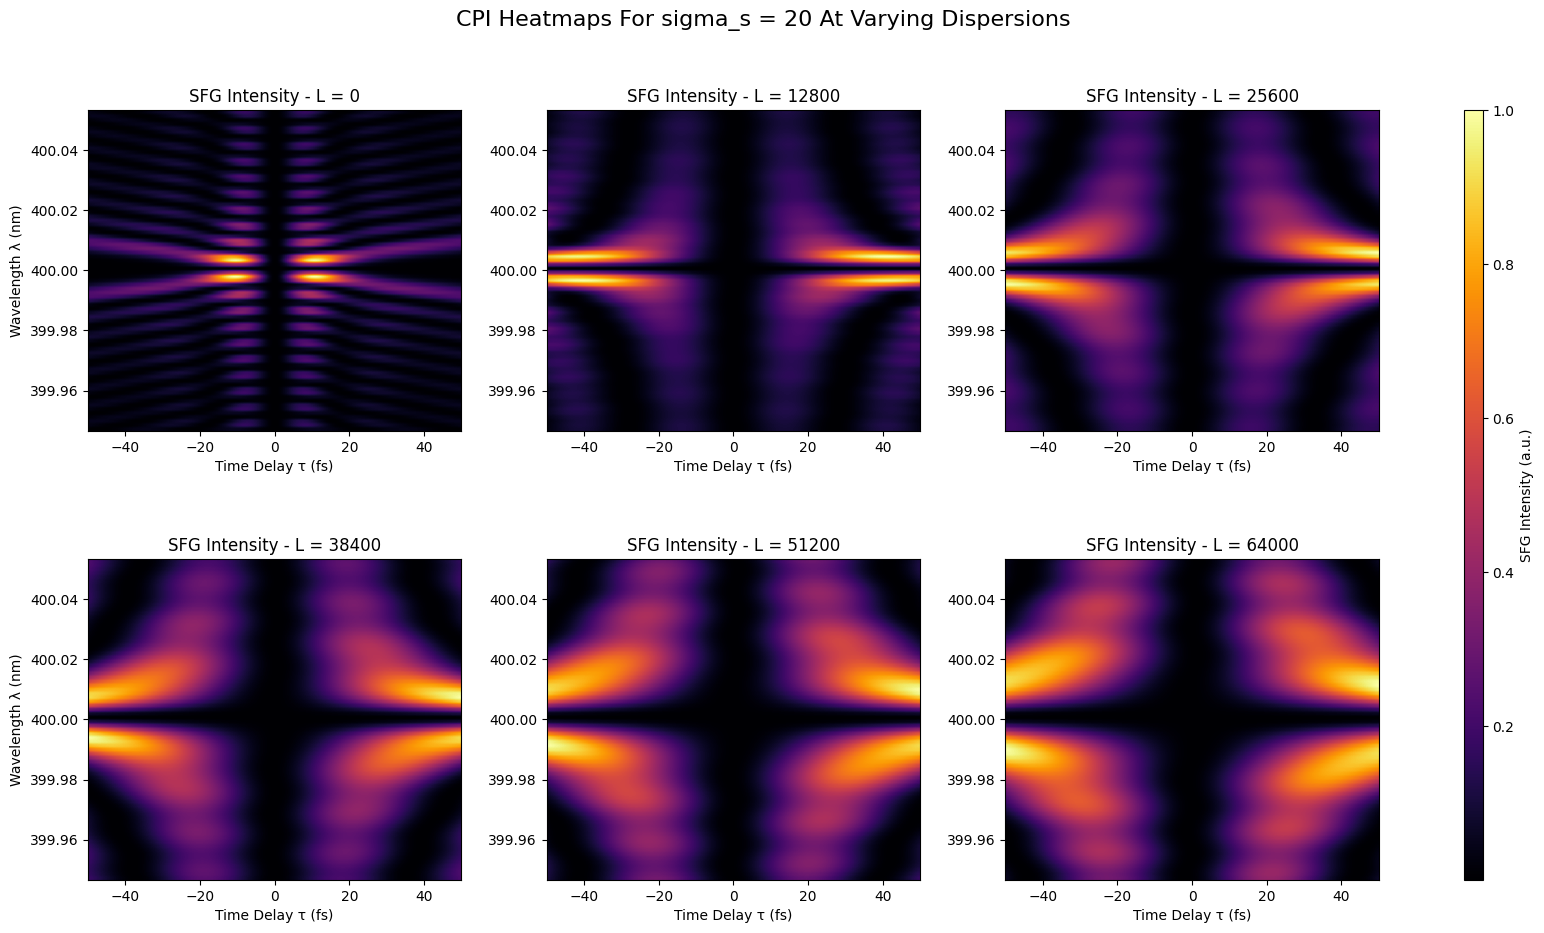

In [21]:
super_duper_sigma = 20
super_duper_B = B*(10/(10+10))

super_duper_erf_pos = erf_2(super_duper_B,ws,w_0,super_duper_sigma)
super_duper_erf_neg = erf_2(-super_duper_B,ws,w_0,super_duper_sigma)

Ec_super_duper_erf = chirper(Ews, super_duper_erf_pos)
Ea_super_duper_erf = chirper(Ews, super_duper_erf_neg)

Ls = [0, 12800, 25600, 38400, 51200, 64000]
titles = ['L = 0', 'L = 12800', 'L = 25600', 'L = 38400', 'L = 51200', 'L = 64000']
super_taus = np.arange(-50, 50+0.5, 0.5)


CPIs = []

for L in Ls:
    cpi = CPI(Ec_super_duper_erf, Ea_super_duper_erf, ws, w_0, super_taus,  0.0223238*L)
    CPIs.append(cpi/np.max(cpi))


# --- Set up figure with GridSpec (2 rows x 3 columns + colorbar) ---
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Create 6 subplots in the 3x2 grid (rows 0 and 1, columns 0-2)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

extent = [super_taus[0], super_taus[-1], wavelengths[end], wavelengths[start]]

# --- Plot heatmaps ---
for ax, data, title in zip(axes, CPIs, titles):
    im = ax.imshow(
        data[:, start:end].T,
        extent=extent,
        origin='lower',
        aspect='auto',
        cmap='inferno'
    )
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(f'SFG Intensity - {title}')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Label the first plot in each row
axes[0].set_ylabel('Wavelength λ (nm)')
axes[3].set_ylabel('Wavelength λ (nm)')

# --- Add colorbar in its own column (on the right) ---
cbar_ax = fig.add_subplot(gs[:, 3])  # spans both rows
fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')

fig.suptitle("CPI Heatmaps For sigma_s = 20 At Varying Dispersions", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title
plt.show()

    

Fit Parameters (t0, a1, a2, fwhm) for Linear CPI: [-4.08322738e-08  1.00017448e+00  1.00017500e+00  1.41420861e+01]
Final Chi-Squared Value for Linear CPI: 4.5346466395096285e-11
Fit Parameters (t0, a1, a2, fwhm) for ERF CPI: [-4.95229169e-08  9.99846388e-01  1.00104929e+00  9.98980166e+00]
Final Chi-Squared Value for ERF CPI: 3.9215771671161943e-05
Fit Parameters (t0, a1, a2, fwhm) for Super ERF CPI: [-4.00427373e-09  9.96563643e-01  1.00492476e+00  8.62814704e+00]
Final Chi-Squared Value for Super ERF CPI: 0.0025910960803418076
Fit Parameters (t0, a1, a2, a3, fwhm) for Linear CPI (parabolic): [-9.11012489e-08  1.00014304e+00 -7.25474376e-08  1.00000429e+00
  1.41416785e+01]
Final Chi-Squared Value for Linear CPI (parabolic): 3.2928346125982067e-09
Fit Parameters (t0, a1, a2, a3, fwhm) for ERF CPI (parabolic): [-2.41945484e-08  1.00063315e+00  2.41745993e-06  1.00123199e+00
  9.99483572e+00]
Final Chi-Squared Value for ERF CPI (parabolic): 2.860210963509332e-05
Fit Parameters (t0, a1,

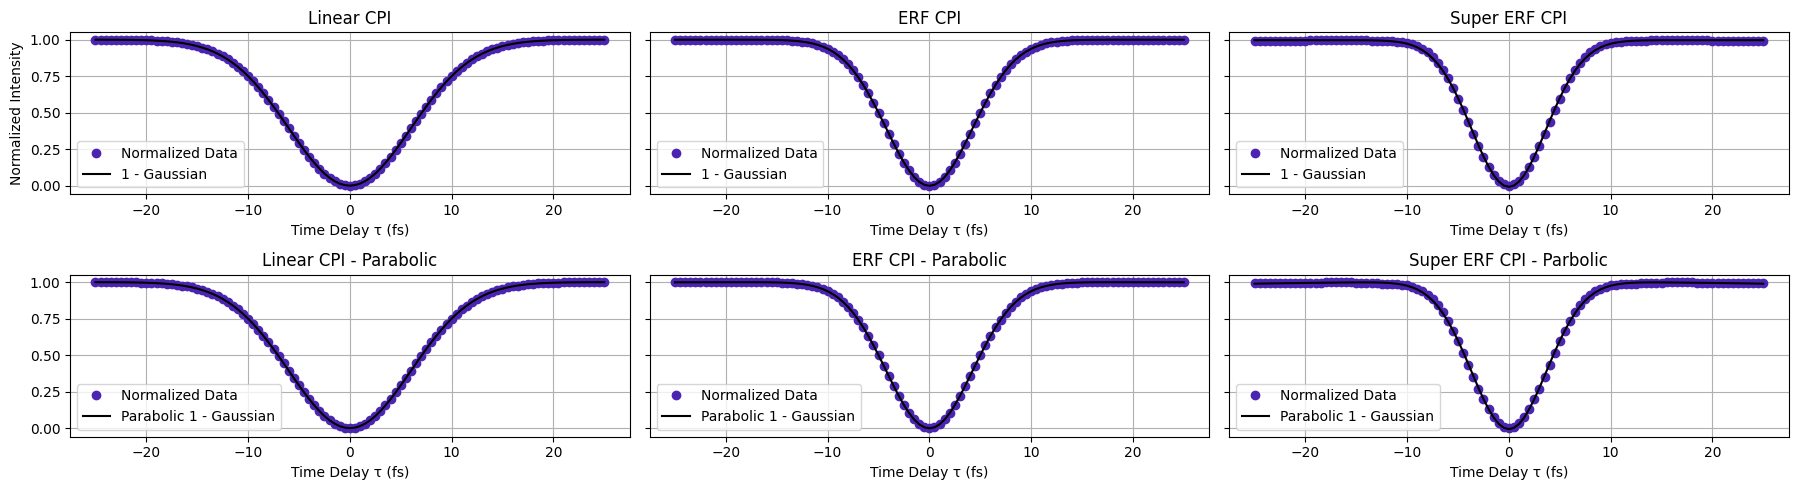

In [7]:
from scipy.optimize import minimize 

signals = []
curve_fits = []
params = []

def one_minus_gaussian(t, t_0, a1, a2, fwhm):
    return a1 - a2*np.exp(-4*math.log(2)*((t - t_0)**2)/fwhm**2)

def parabolic_one_minus_gaussian(t, t_0, a1, a2, a3, fwhm):
    return (a1 - a2*(t - t_0)**2)*(1 - a3*np.exp(-4*math.log(2)*((t - t_0)**2)/fwhm**2))

def chisq(params, t, y):
    t0, a1, a2, fwhm = params
    model = one_minus_gaussian(t, t0, a1, a2, fwhm)
    return np.sum((y - model)**2)

def chisq_parabolic(params, t, y):
    t0, a1, a2, a3, fwhm = params
    model = parabolic_one_minus_gaussian(t, t0, a1, a2, a3, fwhm)
    return np.sum((y - model)**2)

fit_names= []

for d, name in zip(datasets, titles):
    SFG_band = d[:, (wavelengths >= 399.5) & (wavelengths <= 400.5)]
    signal_vs_tau = np.sum(SFG_band, axis=1)  # integrate over wavelength axis

    signal_vs_tau_norm = (signal_vs_tau - np.min(signal_vs_tau))/(np.max(signal_vs_tau) - np.min(signal_vs_tau))
    signals.append(signal_vs_tau_norm)

    # --- Initial guesses ---
    init_guess = [0.0, 0.0025, 0.9, 10.0]  # Corrected to 3 parameters

    # --- Fit the data ---
    result = minimize(chisq, init_guess, args=(taus, signal_vs_tau_norm), method='L-BFGS-B')

    # Extract the parameters
    params.append(result.x)

    # Calculate the final chi-squared values
    final_chisq = chisq(result.x, taus, signal_vs_tau_norm)

    # Print the fit parameters and chi-squared values
    print(f"Fit Parameters (t0, a1, a2, fwhm) for {name}: {result.x}")
    print(f"Final Chi-Squared Value for {name}: {final_chisq}")

    # Evaluate the fits
    curve_fits.append(one_minus_gaussian(taus, *result.x))
    fit_names.append("1 - Gaussian")

#parabolic
for d, name in zip(datasets, titles):
    SFG_band = d[:, (wavelengths >= 399.5) & (wavelengths <= 400.5)]
    signal_vs_tau = np.sum(SFG_band, axis=1)  # integrate over wavelength axis
    signal_vs_tau_norm = (signal_vs_tau - np.min(signal_vs_tau))/(np.max(signal_vs_tau) - np.min(signal_vs_tau))
    signals.append(signal_vs_tau_norm)

    # --- Initial guesses ---
    init_guess_parabolic = [0, 0.0025, 0.00000001, 0.9, 10]

    # --- Fit the data ---
    result2 = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, signal_vs_tau_norm), method='L-BFGS-B')

    # Extract the parameters
    params.append(result2.x)

    # Calculate the final chi-squared values
    final_chisq2 = chisq_parabolic(result2.x, taus, signal_vs_tau_norm)

    # Print the fit parameters and chi-squared values

    print(f"Fit Parameters (t0, a1, a2, a3, fwhm) for {name} (parabolic): {result2.x}")
    print(f"Final Chi-Squared Value for {name} (parabolic): {final_chisq2}")

    # Evaluate the fits
    curve_fits.append(parabolic_one_minus_gaussian(taus, *result2.x))

    fit_names.append("Parabolic 1 - Gaussian")

complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name, fit in zip(axes, signals, curve_fits, complete_titles, fit_names):
    ax.plot(taus, signal, 'o', label='Normalized Data', color='#4B25B1')
    ax.plot(taus, curve, '-', label=fit, color='black')
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.legend()
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
plt.tight_layout()
plt.show();

In [ ]:
Lvals = np.arange(0, 64001, 800)

#i wanna make this go into results folders
for L in Lvals:
    lin_cpi = CPI(Ec_lin, Ea_lin, ws, w_0, taus, 0.0223238*L)
    erf_cpi = CPI(Ec_erf, Ea_erf, ws, w_0, taus, 0.0223238*L)
    superf_cpi = CPI(Ec_superf, Ea_superf, ws, w_0, taus, 0.0223238*L)

    SFG_band_lin = lin_cpi[:, (wavelengths >= 399.5) & (wavelengths <= 400.5)]
    signal_vs_tau_lin = np.sum(SFG_band_lin, axis=1)
    np.savetxt(f"./linear_results/Linear_dip_{L}.txt", signal_vs_tau_lin, fmt="%.15f")

    SFG_band_erf = erf_cpi[:, (wavelengths >= 399.5) & (wavelengths <= 400.5)]
    signal_vs_tau_erf = np.sum(SFG_band_erf, axis=1)
    np.savetxt(f"./erf_results/ERF_dip_{L}.txt", signal_vs_tau_erf, fmt="%.15f")

    SFG_band_superf = superf_cpi[:, (wavelengths >= 399.5) & (wavelengths <= 400.5)]
    signal_vs_tau_superf = np.sum(SFG_band_superf, axis=1)
    np.savetxt(f"./super_erf_results/Super_ERF_dip_{L}.txt", signal_vs_tau_superf, fmt="%.15f")



L = 16000, FWHM = 10.01 fs


'plt.plot(Lvals, lin_fwhms, label = "linear")\nplt.plot(Lvals, erf_fwhms, label = "erf")\nplt.plot(Lvals, superf_fwhms, label = "super-erf")\nplt.ylim(0, 30)'

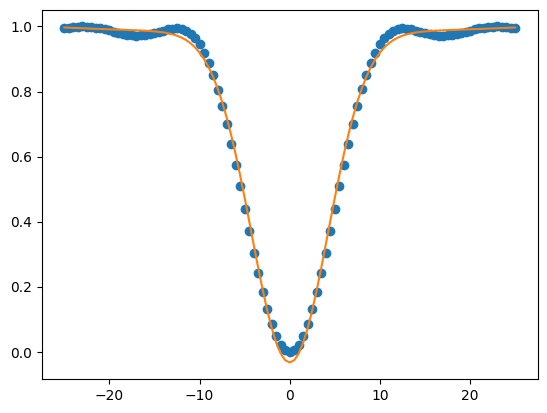

In [ ]:
from scipy.optimize import differential_evolution
Lvals = np.arange(0, 64001, 800)
lin_fwhms = []
erf_fwhms = []
superf_fwhms = []

# --- Initial guesses ---
init_guess_parabolic = [0, 0.0025, 0.00000001, 0.9, 10]

bounds = [(-10, 10), (0, 0.01), (0, 1e-4), (0, 1), (5, 40)]

def robust_fit(y_data):
    # Try L-BFGS-B first
    result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, y_data), method='L-BFGS-B')
    
    # Check for bad fits (e.g., negative width or high chi-squared)
    if result.fun > 0.01 or result.x[4] < 0:
        print("⚠️  Re-fitting with differential_evolution...")
        result = differential_evolution(lambda p: chisq_parabolic(p, taus, y_data), bounds)
    
    return result

for L in Lvals:
    lin_sig = np.loadtxt(f"./linear_results/Linear_dip_{L}.txt")
    erf_sig = np.loadtxt(f"./erf_results/ERF_dip_{L}.txt")
    superf_sig = np.loadtxt(f"./super_erf_results/Super_ERF_dip_{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    # --- Fit the data ---
    lin_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, lin_norm), method='L-BFGS-B')
    #erf_result = robust_fit(erf_norm)
    #superf_result = robust_fit(superf_norm)
    erf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, erf_norm), method='L-BFGS-B')
    superf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, superf_norm), method='L-BFGS-B')

    
    lin_fwhms.append(lin_result.x[4])
    erf_fwhms.append(erf_result.x[4])
    superf_fwhms.append(superf_result.x[4])

    if L in [16000]:
        print(f"L = {L}, FWHM = {erf_result.x[4]:.2f} fs")
        plt.plot(taus, erf_norm,'o')
        plt.plot(taus, parabolic_one_minus_gaussian(taus, *erf_result.x))
    
Lvals_mm = Lvals/10000
#basinhopping 
'''plt.plot(Lvals, lin_fwhms, label = "linear")
plt.plot(Lvals, erf_fwhms, label = "erf")
plt.plot(Lvals, superf_fwhms, label = "super-erf")
plt.ylim(0, 30)'''
    

(0.0, 30.0)

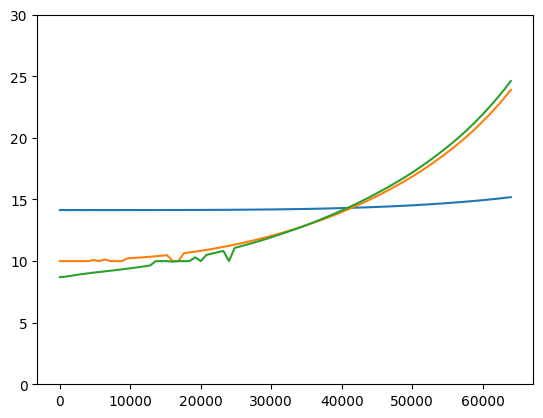

In [11]:
plt.plot(Lvals, lin_fwhms, label = "linear")
plt.plot(Lvals, erf_fwhms, label = "erf")
plt.plot(Lvals, superf_fwhms, label = "super-erf")
plt.ylim(0, 30)

In [ ]:
import sympy as sy

def epsilon_derivative(order, w0_val):
    # Define symbolic variable
    w = sy.Symbol('w', real=True)

    # Constants (same units as in Mathematica: um/fs)
    c = 0.2998
    b1 = 1.03961212
    b2 = 0.231792344
    b3 = 1.01046945
    c1 = 6.00069867e-3
    c2 = 2.00179144e-2
    c3 = 1.03560653e2

    # Sellmeier n(w)
    omega = 2 * sy.pi * c / w
    n_squared = 1 + (b1 * omega**2)/(omega**2 - c1) + \
                    (b2 * omega**2)/(omega**2 - c2) + \
                    (b3 * omega**2)/(omega**2 - c3)
    n_w = sy.sqrt(n_squared)

    # Phase constant
    k_w = n_w * w / c

    # Derivative of desired order
    dkw = sy.diff(k_w, w, order)

    # Substitute w0 value
    epsilon = (L_val / 2) * dkw.subs(w, w0_val).evalf()

    return epsilon


In [ ]:
ws[0] = 1e-6

def BK7_epsilon(w, w0):
    c = 0.2998; #(*um/fs*)
    b1 = 1.03961212; #(*for BK7 glass*)
    b2 = 0.231792344
    b3 = 1.01046945
    c1 = 6.00069867e-3 #(*um^2*)
    c2 = 2.00179144e-2
    c3 = 1.03560653e2

    k_w = w*(np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) + 
                     (b2*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c2) + 
                     (b3*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c3)))/c
    
    k_deriv = np.sqrt(1 +((4*b1*(c**2)*(np.pi**2))/(-c1*((w - w0)**2) + (2*c*np.pi)**2)) + 
                      ((4*b2*(c**2)*(np.pi**2))/(-c2*((w - w0)**2) + (2*c*np.pi)**2)) + 
                      ((4*b3*(c**2)*(np.pi**2))/(-c3*((w - w0)**2) + (2*c*np.pi)**2)))/c + (w - w0)*(
                          (32*b1*(c*np.pi)**4)/(((w - w0)**5)*((-c1 + ((2*c*np.pi)**2)/((w - w0)**2))**2)) +
                          (32*b2*(c*np.pi)**4)/(((w - w0)**5)*((-c2 + ((2*c*np.pi)**2)/((w - w0)**2))**2)) +
                          (32*b3*(c*np.pi)**4)/(((w - w0)**5)*((-c3 + ((2*c*np.pi)**2)/((w - w0)**2))**2)) -
                          (8*b1*(c*np.pi)**2)/(((w - w0)**3)*(-c1 + ((2*c*np.pi)**2)/((w - w0)**2))) -
                          (8*b2*(c*np.pi)**2)/(((w - w0)**3)*(-c2 + ((2*c*np.pi)**2)/((w - w0)**2))) -
                          (8*b3*(c*np.pi)**2)/(((w - w0)**3)*(-c3 + ((2*c*np.pi)**2)/((w - w0)**2))))/(
                              2*c*np.sqrt(1 + (b1*(2*np.pi*c/(w - w0))**2)/((2*np.pi*c/(w - w0))**2 - c1) + 
                                          (b2*(2*np.pi*c/(w - w0))**2)/((2*np.pi*c/(w - w0))**2 - c2) + 
                                          (b3*(2*np.pi*c/(w - w0))**2)/((2*np.pi*c/(w - w0))**2 - c3)))

    return k_w - k_deriv


phase_test = BK7_epsilon( ws, w_0)

print(phase_test)


[-0.28507039  4.99415888]


# THIS DOESNT WORK
Idea: use numpys broadcasting to make all array sizes the same, so then we can use vectorization to get rid of the very slow loop 
Reality: semi bricks your computer, likely bc you dont have enough RAM according to chatgpt -> takes about 10-20s longer and makes your computer shit itself in the process -> likely need > 16gb, probably 32 

for some reasons maggies plot is one pixel wider on the y-axis than mine. is this because i removed the first points where w = 0?

taus = np.arange(-25, 25 + 0.5, 0.5)  # shape (N_tau,)
N_tau = taus.shape[0]

# Shape (1, N_freq) for broadcasting
ws_b = ws[np.newaxis, :]  # shape (1, N_freq)
taus_b = taus[:, np.newaxis]  # shape (N_tau, 1)

# Reference electric field (Ec + Ea) repeated over taus
Eref_w = (Ec_lin + Ea_lin)[np.newaxis, :] * np.exp(1j * ws_b * taus_b)  # shape (N_tau, N_freq)

# Sample electric field: fixed in time
Esamp_w = Esampler(Ec_lin, Ea_lin, ws, w_0, 0)
Esamp_t = np.conj(ifft(np.conj(Esamp_w), norm='ortho'))  # shape (N_freq,)

# IFFT Eref to time domain
Eref_t = np.conj(ifft(np.conj(Eref_w), axis=1, norm='ortho'))  # shape (N_tau, N_freq)

# Multiply in time domain (broadcast Esamp_t to all taus)
Esfg_t = Eref_t * Esamp_t[np.newaxis, :]  # shape (N_tau, N_freq)

# FFT back to frequency domain
Esfg_w = np.conj(fft(np.conj(Esfg_t), axis=1, norm='ortho'))  # shape (N_tau, N_freq)

# Compute intensity
SFG_data = np.abs(Esfg_w)**2  # shape (N_tau, N_freq)

wavelengths = 2*np.pi*c*1e9/(ws*1e15)

start = 299753
end = 299833

SFG_data_norm = SFG_data / np.max(SFG_data)

# Plot
plt.figure(figsize=(8, 6))
extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

plt.imshow(
    SFG_data_norm[:, start:end].T,
    extent=extent,
    origin='lower',
    aspect='auto',
    cmap='inferno'
)

plt.colorbar(label='SFG Intensity (a.u.)')
plt.xlabel('Time Delay τ (fs)')
plt.ylabel('Wavelength λ (nm)')
plt.title('SFG Intensity vs Time Delay and Wavelength')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.tight_layout()
plt.show()



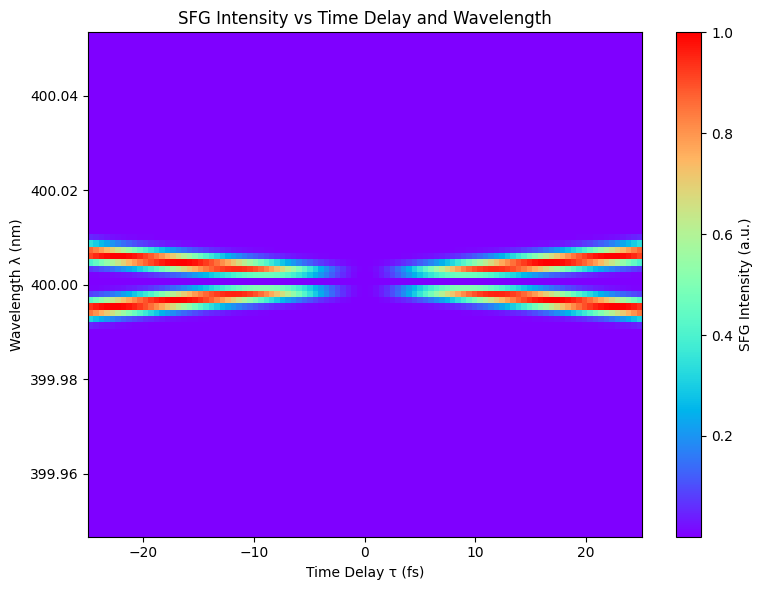

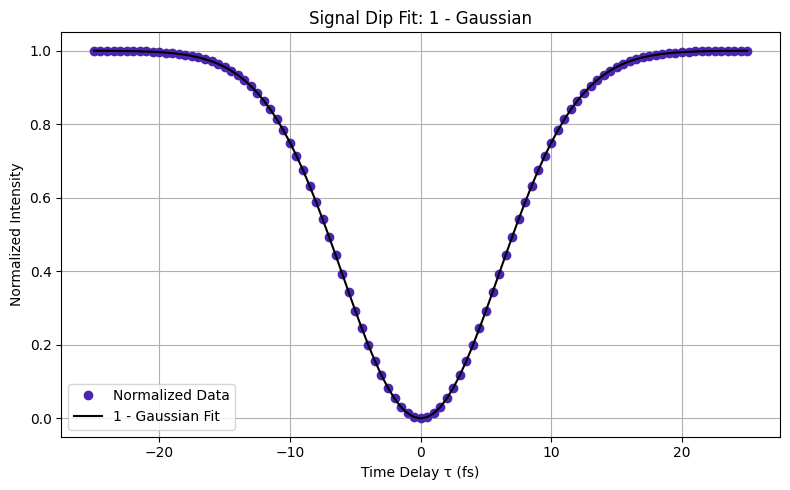

Fitted parameters: a = -0.0000, t0 = 1.00 fs, FWHM = 14.14 fs
